# Image registration (spatial alignment)

In [1]:
import warnings
import requests
from tempfile import mkstemp
from pathlib import Path
import numpy as np
import nibabel as nb

from eddymotion.dmri import DWI
from eddymotion.viz import plot_dwi
from eddymotion.estimator import _advanced_clip

warnings.filterwarnings("ignore")

url = "https://files.osf.io/v1/resources/8k95s/providers/osfstorage/6070b4c2f6585f03fb6123a2"
datapath = Path(mkstemp(suffix=".h5")[1])
if datapath.stat().st_size == 0:
    datapath.write_bytes(
        requests.get(url, allow_redirects=True).content
    )

dmri_dataset = DWI.from_filename(datapath)
datapath.unlink()


def _to_nifti(
    data, affine, filename, clip=True
):
    data = np.squeeze(data)
    if clip:
        data = _advanced_clip(data)
    nb.Nifti1Image(
        data,
        affine,
        None,
    ).to_filename(filename)

At this point of the tutorial we have covered two of the three initial requirements:

* we have a powerful data structure to access our dMRI dataset with agility, and
* we have a reliable (thanks to DIPY!) model factory to generate *motion-less* references.

Therefore, we are only one step away from our goal - aligning any given DW map with the *motion-less* reference.
The estimation of the ***spatial transform*** that brings two maps into alignment is called ***image registration***.

**Image registration** is therefore the process through which we bring the structural features of two images into alignment.
This means that, brain sulci and gyri, the ventricles, subcortical structures, etc. are located exactly at the same place in the two images.
That allows, for instance, for **image fusion**, and hence screening both images together (for example, applying some transparency to the one on top) should not give us the perception that they *are not aligned*.

## ANTs - Advanced Normalization ToolS

The [ANTs toolbox](http://stnava.github.io/ANTs/) is widely recognized as a powerful image registration (and *normalization*, which is registration to some standard space) framework.

The output of an image registration process is the *estimated transform* that brings the information in the two images into alignment.
In our case, the head-motion is a rigid-body displacement of the head.
Therefore, a very simple (*linear*) model --an affine $4\times 4$ matrix-- can be used to formalize the *estimated transforms*.

Only very recently, [ANTs offers a Python interface](https://doi.org/10.1101/2020.10.19.20215392) to run their tools.
For this reason, we will use the very much consolidated [*Nipype* wrapping of the ANTs' command-line interface](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.ants.html#registration).
The code is *almost* as simple as follows:

```python
from nipype.interfaces.ants import Registration

registration_framework = Registration(
    fixed_image="reference.nii.gz",
    moving_image="left-out-gradient.nii.gz",
    from_file="settings-file.json"
)
```

At the minimum, we need to establish our registration framework using the *fixed* (our synthetic, motion-less reference) and the *moving* (the left-out gradient) images.
We can *easily* configure registration by creating a `settings-file.json` that may look like the following:

```JSON
{
  "collapse_output_transforms": true,
  "convergence_threshold": [ 1E-5, 1E-6 ],
  "convergence_window_size": [ 5, 2 ],
  "dimension": 3,
  "initialize_transforms_per_stage": false,
  "interpolation": "BSpline",
  "metric": [ "Mattes", "Mattes" ],
  "metric_weight": [ 1.0, 1.0 ],
  "number_of_iterations": [
    [ 100, 50, 0 ],
    [ 10 ]
  ],
  "radius_or_number_of_bins": [ 32, 32 ],
  "sampling_percentage": [ 0.05, 0.1 ],
  "sampling_strategy": [ "Regular", "Random" ],
  "shrink_factors": [
    [ 2, 2, 1 ],
    [ 1 ]
  ],
  "sigma_units": [ "vox", "vox" ],
  "smoothing_sigmas": [
    [ 4.0, 2.0, 0.0 ],
    [ 0.0 ]
  ],
  "transform_parameters": [
    [ 0.01 ],
    [ 0.01 ]
  ],
  "transforms": [ "Rigid", "Rigid" ],
  "use_estimate_learning_rate_once": [ false, true ],
  "use_histogram_matching": [ true, true ],
  "verbose": true,
  "winsorize_lower_quantile": 0.0001,
  "winsorize_upper_quantile": 0.9998,
  "write_composite_transform": false
}
```

Yes, configuring image registration is definitely not *straightforward*.
The most relevant piece of settings to highlight is the `"transforms"` key, where we can observe we will be using a `"Rigid"` transform model.

## Example registration

It is beyond the scope of this tutorial to understand ANTs and/or image registration altogether, but let's have a look at how registration is integrated.
First, we'll need to generate one target gradient prediction following all the steps learned previously.
For this example, we have selected the 8<sup>th</sup> DW map (`index=7`) because it contains a sudden motion spike, resembling a nodding movement.

In [2]:
from eddymotion.model import ModelFactory

data_train, data_test = dmri_dataset.logo_split(7, with_b0=True)

model = ModelFactory.init(
    gtab=data_train[1],
    model="DTI",
    S0=dmri_dataset.bzero,
)
model.fit(data_train[0])
predicted = model.predict(data_test[1])

Since we are using the command-line interface of ANTs, the software must be installed in the computer and the input data is provided via files in the filesystem.
Let's write out two NIfTI files in a temporary folder:

In [3]:
from pathlib import Path
from tempfile import mkdtemp

tempdir = Path(mkdtemp())

# The fixed image is our prediction
fixed_path = tempdir / "fixed.nii.gz"
_to_nifti(predicted, dmri_dataset.affine, fixed_path)

# The moving image is the left-out DW map
moving_path = tempdir / "moving.nii.gz"
_to_nifti(data_test[0], dmri_dataset.affine, moving_path)

We can now visualize our reference (the prediction) and the actual DW map.
Please notice the subtle *nodding* of the head, perhaps more apparent when looking at the corpus callosum in the sagittal views:

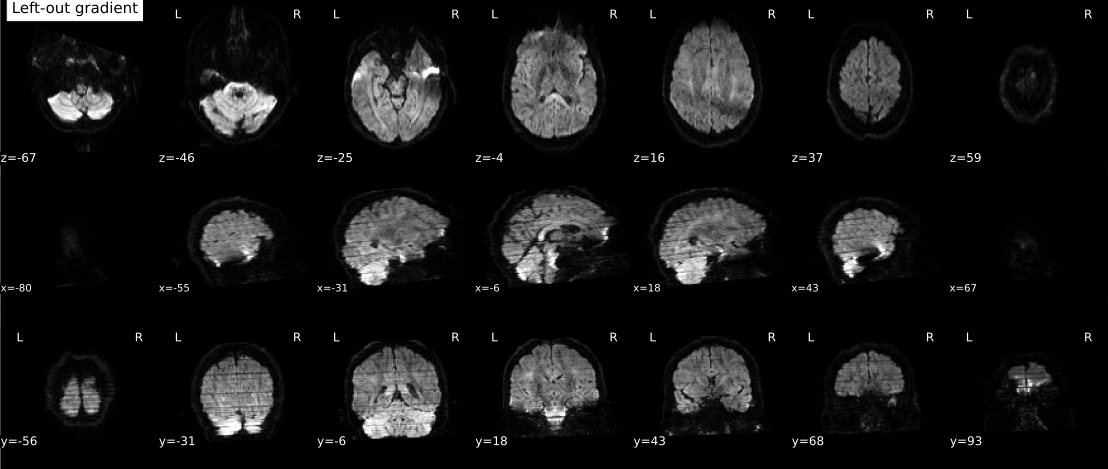

In [4]:
from niworkflows.viz.notebook import display

display(
    fixed_path,
    moving_path,
    fixed_label="Predicted",
    moving_label="Left-out gradient",
);

Let's configure ANTs via NiPype:

In [5]:
from os import cpu_count
from pkg_resources import resource_filename as pkg_fn
from nipype.interfaces.ants.registration import Registration

registration = Registration(
    terminal_output="file",
    from_file=pkg_fn(
        "eddymotion",
        f"config/dwi-to-dwi_level1.json",
    ),
    fixed_image=str(fixed_path.absolute()),
    moving_image=str(moving_path.absolute()),
)
registration.inputs.output_warped_image = True
registration.inputs.num_threads = cpu_count()

which will run the following command-line:

In [6]:
registration.cmdline

'antsRegistration --collapse-output-transforms 1 --dimensionality 3 --initialize-transforms-per-stage 0 --interpolation BSpline --output [ transform, transform_Warped.nii.gz ] --transform Rigid[ 0.01 ] --metric GC[ /tmp/tmp2ykq7pa2/fixed.nii.gz, /tmp/tmp2ykq7pa2/moving.nii.gz, 1, 32, Regular, 0.05 ] --convergence [ 100x50x10, 1e-06, 5 ] --smoothing-sigmas 4.0x2.0x2.0vox --shrink-factors 4x2x1 --use-estimate-learning-rate-once 0 --use-histogram-matching 1 --transform Affine[ 0.001 ] --metric GC[ /tmp/tmp2ykq7pa2/fixed.nii.gz, /tmp/tmp2ykq7pa2/moving.nii.gz, 1, 32, Random, 0.1 ] --convergence [ 50, 1e-07, 2 ] --smoothing-sigmas 0.0vox --shrink-factors 1 --use-estimate-learning-rate-once 1 --use-histogram-matching 1 -v --winsorize-image-intensities [ 0.0001, 0.9998 ]  --write-composite-transform 0'

Nipype interfaces can be submitted for execution with the `run()` method:

In [7]:
result = registration.run(cwd=str(tempdir.absolute()))

If everything worked out, we can now retrieve the aligned file with the output `result.outputs.warped_image`.
We can now visualize how close (or far) the two images are:

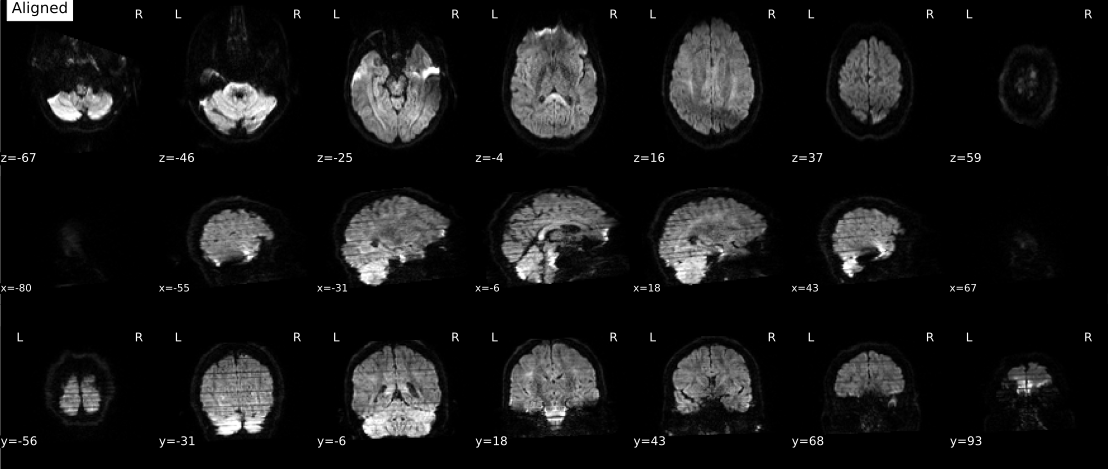

In [8]:
display(
    fixed_path,
    result.outputs.warped_image,
    fixed_label="Predicted",
    moving_label="Aligned",
);

## Resampling an image

Once we have estimated what is the *transform* that brings two images into alignment, we can *bring* the data in the *moving* image and *move this image* into the *reference*'s grid through *resampling*.

The process works as follows:

![nitransforms](https://raw.githubusercontent.com/poldracklab/nitransforms/master/docs/_static/figure1-joss.png)

[*NiTransforms*](https://doi.org/10.1109/ISBI45749.2020.9098466) ([open-access pre-print here](https://doi.org/10.31219/osf.io/8aq7b)) is an ongoing project to bring a compatibility layer into *NiBabel* between the many transform file formats generated by neuroimaging packages.
We will be using *NiTransforms* to *apply* these transforms we estimate with ANTs -- effectively *resampling* moving images into their reference's grid.

To read a transform produced by ANTs with *NiTransforms*, we use the following piece of code:

In [9]:
import nitransforms as nt

itk_xform = nt.io.itk.ITKLinearTransform.from_filename(result.outputs.forward_transforms[0])
matrix = itk_xform.to_ras(reference=fixed_path, moving=moving_path)
matrix

KeyError: 'AffineTransform_float_3_3'

Resampling an image requires two pieces of information: the *reference* image (which provides the new grid where we want to have the data) and the *moving* image which contains the actual data we are interested in:

In [ ]:
xfm = nt.linear.Affine(matrix)
xfm.reference = fixed_path
resampled = xfm.apply(moving_path)
resampled.to_filename(tempdir / "resampled-nitransforms.nii.gz")
display(
    fixed_path,
    tempdir / "resampled-nitransforms.nii.gz",
    fixed_label="Predicted",
    moving_label="Aligned (nitransforms)",
);

**Exercise**

Use the `display()` function to visualize the image aligned as generated by ANTs vs. that generated by *NiTransforms* -- they should be aligned!.

**Solution**

In [ ]:
display(
    result.outputs.warped_image,
    tempdir / "resampled-nitransforms.nii.gz",
    fixed_label="Aligned (ANTs)",
    moving_label="Aligned (nitransforms)",
);